# Probabilitic Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pth
import torch
import torch.distributions as torchdist
import torchvision
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
class NormalDistLayer(torch.nn.Module):
    def __init__(self, n_latent_dim, n_classes):
        super(NormalDistLayer, self).__init__()
        self.n_latent_dim = n_latent_dim
        self.n_classes = n_classes
        
        # mu and sigma represent mean and var of Normal distribution of  N classes.
        self.mu = torch.nn.Parameter(torch.FloatTensor(n_classes, n_latent_dim))
        self.log_sigma = torch.nn.Parameter(torch.FloatTensor(n_classes, n_latent_dim))
        # self.mu = torch.nn.Parameter(torch.tensor([[0., 0.], [2., 0.]]))
        # self.log_sigma = torch.nn.Parameter(torch.tensor([[0., 0.], [-0.5, -0.5]]))
        torch.nn.init.xavier_uniform_(self.mu)
        torch.nn.init.xavier_uniform_(self.log_sigma)
        
        self.epsilon = 1e-7
        
    def forward(self, z_mu, z_log_sigma):
        """
        Parameters
        ----------
        z_mu: torch.Tensor, shape of (batch, n_latent_dim)
        z_log_sigma: torch.Tensor, shape of (batch, n_latent_dim)
        """
        z_sigma = torch.exp(z_log_sigma)
        sigma = torch.exp(self.log_sigma)
        
        sims = []
        batch_size = z_mu.size(0)
        for i in range(batch_size):
            # shape of (n_classes, n_latent_dim)
            # print('mu: %s' % str(self.mu.detach().numpy()))
            # print('z_mu[i]: %s' % str(z_mu[i].detach().numpy()))
            diff_mu = self.mu - z_mu[i]
            # sum_sigma = sigma**2 + z_sigma[i]**2
            # print('diff_mu: %s sum_sigma: %s' % 
            #      (str(diff_mu.detach().numpy()), str(sum_sigma.detach().numpy())))
            # return
            # shape of (n_classes,)
            # sim = 1/2 * (diff_mu**2 / (sum_sigma + self.epsilon) 
            #               + torch.log(sum_sigma + self.epsilon)).sum(dim=1)
            sim = (diff_mu**2).sum(dim=1)
            #print('sim: %s' % sim.detach().numpy())
            sims.append(sim)
            
            
        
        # shape of (batch, n_classes)
        sims = torch.stack(sims, dim=0)
        
        return sims

class NormalLinear(torch.nn.Module):
    def __init__(self):
        super(NormalLinear, self).__init__()
        self.fc = torch.nn.Linear(4, 10)
        
    def forward(self, z_mu, z_log_sigma):
        x = torch.cat([z_mu, z_log_sigma], dim=1)
        x = self.fc(x)
        
        return x

In [3]:
model = NormalDistLayer(2, 2)

In [4]:
x_mu = torch.tensor([1., 0.]).view(1, 2)
x_log_sigma = torch.tensor([0., 0.]).view(1, 2)

In [5]:
model(x_mu, x_log_sigma)

tensor([[1.9471, 0.4090]], grad_fn=<StackBackward>)

In [6]:
class ConvNet(torch.nn.Module):
    def __init__(self, n_latent_dim):
        super(ConvNet, self).__init__()
        self.n_latent_dim = n_latent_dim
        
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, 3),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(8, 16, 3),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 3),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.fc = torch.nn.Linear(32, 2*n_latent_dim)        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # GAP
        x = F.relu(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        z_mu = x[:, :self.n_latent_dim]
        z_log_sigma = x[:, self.n_latent_dim:]
        # print('z_mu size: %s z_log_sigma size: %s' % (z_mu.size(), z_log_sigma.size()))
        # print('z_mu: %s z_log_sigma: %s' % (z_mu.detach().numpy(), z_log_sigma.detach().numpy()))
        
        return z_mu, z_log_sigma
    
class ConvNet2(torch.nn.Module):
    def __init__(self, n_latent_dim):
        super(ConvNet2, self).__init__()
        self.n_latent_dim = n_latent_dim
        
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, 3),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(8, 16, 3),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 3),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.fc = torch.nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # GAP
        x = F.relu(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x

## mnist

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [8]:
trn_trnsfms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485],
        std=[0.220]
    )
])

train_dataset = torchvision.datasets.MNIST('../data', transform=trn_trnsfms)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=64,
                                           shuffle=True,
                                           drop_last=True
                                          )

In [9]:
N_DIM = 2
N_CLASSES = 10

model = ConvNet(N_DIM)
norm_dist_layer = NormalDistLayer(N_DIM, N_CLASSES)
# norm_dist_layer = NormalLinear()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([{'params': model.parameters()}, {
                 'params': norm_dist_layer.parameters()}], lr=1e-3)
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [10]:
def train():
    for epoch in range(50):
        loss_meter = AverageMeter()
        top1 = AverageMeter()
        top5 = AverageMeter()
        
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            img, label = data
            
            with torch.set_grad_enabled(True):
                z_mu, z_log_sigma = model(img)
                logit = norm_dist_layer(z_mu, z_log_sigma)
                # print(logit.size())
                # logit = model(img)
                loss = criterion(logit, label)

                prec1, prec5 = accuracy(logit.detach(), label, topk=(1, 5))
                loss_meter.update(loss.item(), img.size(0))
                top1.update(prec1.item(), img.size(0))
                top5.update(prec5.item(), img.size(0))

                # backward
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            
            # print('mu', norm_dist_layer.mu.detach().numpy())
            # print('sigma', torch.exp(norm_dist_layer.log_sigma).detach().numpy())
            
            if (i + 1) % 10 == 0:
                print("Epoch %d train loss %f top1 %f top5 %f" % (epoch, loss_meter.avg, top1.avg, top5.avg))
                    

In [11]:
train()

  1%|▊                                                                                 | 9/937 [00:02<04:03,  3.81it/s]

Epoch 0 train loss 2.302549 top1 12.031250 top5 50.000000


  2%|█▋                                                                               | 19/937 [00:05<03:35,  4.27it/s]

Epoch 0 train loss 2.296880 top1 12.265625 top5 48.671875


  3%|██▌                                                                              | 29/937 [00:07<04:24,  3.44it/s]

Epoch 0 train loss 2.288230 top1 12.500000 top5 49.843750


  4%|███▎                                                                             | 39/937 [00:10<03:53,  3.84it/s]

Epoch 0 train loss 2.283179 top1 12.695312 top5 50.078125


  5%|████▏                                                                            | 49/937 [00:13<03:49,  3.87it/s]

Epoch 0 train loss 2.279106 top1 13.000000 top5 50.843750


  6%|█████                                                                            | 59/937 [00:15<03:35,  4.08it/s]

Epoch 0 train loss 2.272876 top1 13.203125 top5 52.343750


  7%|█████▉                                                                           | 69/937 [00:18<04:05,  3.54it/s]

Epoch 0 train loss 2.268107 top1 13.437500 top5 53.303571


  8%|██████▊                                                                          | 79/937 [00:21<03:52,  3.70it/s]

Epoch 0 train loss 2.261387 top1 13.886719 top5 54.375000


  9%|███████▋                                                                         | 89/937 [00:23<03:51,  3.67it/s]

Epoch 0 train loss 2.252285 top1 14.531250 top5 56.093750


 11%|████████▌                                                                        | 99/937 [00:26<03:30,  3.97it/s]

Epoch 0 train loss 2.241707 top1 15.390625 top5 57.421875


 12%|█████████▎                                                                      | 109/937 [00:29<03:46,  3.66it/s]

Epoch 0 train loss 2.233959 top1 15.781250 top5 58.409091


 13%|██████████▏                                                                     | 119/937 [00:31<03:39,  3.73it/s]

Epoch 0 train loss 2.225472 top1 16.341146 top5 59.075521


 14%|███████████                                                                     | 129/937 [00:34<03:40,  3.66it/s]

Epoch 0 train loss 2.215235 top1 16.778846 top5 60.180288


 15%|███████████▊                                                                    | 139/937 [00:37<03:20,  3.99it/s]

Epoch 0 train loss 2.208628 top1 16.953125 top5 60.892857


 16%|████████████▋                                                                   | 149/937 [00:39<03:17,  3.99it/s]

Epoch 0 train loss 2.200447 top1 17.208333 top5 61.906250


 17%|█████████████▌                                                                  | 159/937 [00:42<02:48,  4.60it/s]

Epoch 0 train loss 2.191025 top1 17.441406 top5 62.910156


 18%|██████████████▍                                                                 | 169/937 [00:44<02:36,  4.91it/s]

Epoch 0 train loss 2.180429 top1 17.886029 top5 63.988971


 19%|███████████████▎                                                                | 179/937 [00:46<02:32,  4.95it/s]

Epoch 0 train loss 2.170564 top1 18.237847 top5 64.852431


 20%|████████████████▏                                                               | 189/937 [00:48<02:46,  4.49it/s]

Epoch 0 train loss 2.162432 top1 18.437500 top5 65.649671


 21%|████████████████▉                                                               | 199/937 [00:50<02:57,  4.15it/s]

Epoch 0 train loss 2.153726 top1 18.570312 top5 66.453125


 22%|█████████████████▊                                                              | 209/937 [00:53<02:58,  4.09it/s]

Epoch 0 train loss 2.143798 top1 18.883929 top5 67.135417


 23%|██████████████████▋                                                             | 219/937 [00:55<02:56,  4.08it/s]

Epoch 0 train loss 2.133628 top1 19.218750 top5 67.862216


 24%|███████████████████▌                                                            | 229/937 [00:58<02:44,  4.30it/s]

Epoch 0 train loss 2.124355 top1 19.436141 top5 68.471467


 26%|████████████████████▍                                                           | 239/937 [01:00<02:54,  4.00it/s]

Epoch 0 train loss 2.113775 top1 19.772135 top5 69.251302


 27%|█████████████████████▎                                                          | 249/937 [01:03<02:37,  4.38it/s]

Epoch 0 train loss 2.104108 top1 20.043750 top5 69.868750


 28%|██████████████████████                                                          | 259/937 [01:05<02:36,  4.33it/s]

Epoch 0 train loss 2.094173 top1 20.276442 top5 70.474760


 29%|██████████████████████▉                                                         | 269/937 [01:07<02:32,  4.39it/s]

Epoch 0 train loss 2.084620 top1 20.515046 top5 70.954861


 30%|███████████████████████▊                                                        | 279/937 [01:09<02:30,  4.38it/s]

Epoch 0 train loss 2.074775 top1 20.825893 top5 71.478795


 31%|████████████████████████▋                                                       | 289/937 [01:12<02:27,  4.41it/s]

Epoch 0 train loss 2.065948 top1 21.056034 top5 71.998922


 32%|█████████████████████████▌                                                      | 299/937 [01:14<02:23,  4.46it/s]

Epoch 0 train loss 2.056583 top1 21.317708 top5 72.588542


 33%|██████████████████████████▍                                                     | 309/937 [01:16<02:22,  4.41it/s]

Epoch 0 train loss 2.046655 top1 21.628024 top5 73.200605


 34%|███████████████████████████▏                                                    | 319/937 [01:19<02:48,  3.67it/s]

Epoch 0 train loss 2.036875 top1 21.855469 top5 73.793945


 35%|████████████████████████████                                                    | 329/937 [01:22<02:43,  3.71it/s]

Epoch 0 train loss 2.026256 top1 22.253788 top5 74.427083


 36%|████████████████████████████▉                                                   | 339/937 [01:24<02:19,  4.28it/s]

Epoch 0 train loss 2.016288 top1 22.500000 top5 74.944853


 37%|█████████████████████████████▊                                                  | 349/937 [01:26<02:17,  4.28it/s]

Epoch 0 train loss 2.006640 top1 22.857143 top5 75.513393


 38%|██████████████████████████████▋                                                 | 359/937 [01:29<02:12,  4.37it/s]

Epoch 0 train loss 1.995984 top1 23.233507 top5 76.019965


 39%|███████████████████████████████▌                                                | 369/937 [01:31<02:43,  3.48it/s]

Epoch 0 train loss 1.985539 top1 23.581081 top5 76.537162


 40%|████████████████████████████████▎                                               | 379/937 [01:34<02:09,  4.30it/s]

Epoch 0 train loss 1.976817 top1 23.910362 top5 76.990132


 42%|█████████████████████████████████▏                                              | 389/937 [01:36<02:07,  4.30it/s]

Epoch 0 train loss 1.966951 top1 24.230769 top5 77.455929


 43%|██████████████████████████████████                                              | 399/937 [01:38<02:01,  4.42it/s]

Epoch 0 train loss 1.957925 top1 24.457031 top5 77.898438


 44%|██████████████████████████████████▉                                             | 409/937 [01:41<02:13,  3.95it/s]

Epoch 0 train loss 1.948819 top1 24.809451 top5 78.311738


 45%|███████████████████████████████████▊                                            | 419/937 [01:44<02:15,  3.81it/s]

Epoch 0 train loss 1.939423 top1 25.200893 top5 78.686756


 46%|████████████████████████████████████▋                                           | 429/937 [01:46<02:12,  3.82it/s]

Epoch 0 train loss 1.930439 top1 25.508721 top5 79.062500


 47%|█████████████████████████████████████▍                                          | 439/937 [01:49<01:57,  4.25it/s]

Epoch 0 train loss 1.920457 top1 25.891335 top5 79.431818


 48%|██████████████████████████████████████▎                                         | 449/937 [01:51<01:57,  4.14it/s]

Epoch 0 train loss 1.911378 top1 26.204861 top5 79.777778


 49%|███████████████████████████████████████▏                                        | 459/937 [01:54<01:58,  4.02it/s]

Epoch 0 train loss 1.901635 top1 26.613451 top5 80.149457


 50%|████████████████████████████████████████                                        | 469/937 [01:56<01:53,  4.11it/s]

Epoch 0 train loss 1.892035 top1 26.884973 top5 80.511968


 51%|████████████████████████████████████████▉                                       | 479/937 [01:59<02:01,  3.78it/s]

Epoch 0 train loss 1.882840 top1 27.180990 top5 80.843099


 52%|█████████████████████████████████████████▊                                      | 489/937 [02:01<01:57,  3.80it/s]

Epoch 0 train loss 1.873669 top1 27.484056 top5 81.176658


 53%|██████████████████████████████████████████▌                                     | 499/937 [02:03<01:45,  4.13it/s]

Epoch 0 train loss 1.864607 top1 27.831250 top5 81.450000


 54%|███████████████████████████████████████████▍                                    | 509/937 [02:06<01:45,  4.04it/s]

Epoch 0 train loss 1.854790 top1 28.213848 top5 81.761642


 55%|████████████████████████████████████████████▎                                   | 519/937 [02:08<01:42,  4.09it/s]

Epoch 0 train loss 1.846661 top1 28.500601 top5 82.016226


 56%|█████████████████████████████████████████████▏                                  | 529/937 [02:11<01:33,  4.36it/s]

Epoch 0 train loss 1.838195 top1 28.808962 top5 82.311321


 58%|██████████████████████████████████████████████                                  | 539/937 [02:13<01:32,  4.30it/s]

Epoch 0 train loss 1.828977 top1 29.123264 top5 82.575231


 59%|██████████████████████████████████████████████▊                                 | 549/937 [02:16<01:35,  4.08it/s]

Epoch 0 train loss 1.820486 top1 29.448864 top5 82.835227


 60%|███████████████████████████████████████████████▋                                | 559/937 [02:18<01:43,  3.67it/s]

Epoch 0 train loss 1.811626 top1 29.804688 top5 83.085938


 61%|████████████████████████████████████████████████▌                               | 569/937 [02:21<01:25,  4.31it/s]

Epoch 0 train loss 1.803329 top1 30.115132 top5 83.325110


 62%|█████████████████████████████████████████████████▍                              | 579/937 [02:23<01:23,  4.26it/s]

Epoch 0 train loss 1.795692 top1 30.382543 top5 83.550647


 63%|██████████████████████████████████████████████████▎                             | 589/937 [02:26<01:25,  4.08it/s]

Epoch 0 train loss 1.787028 top1 30.638242 top5 83.779131


 64%|███████████████████████████████████████████████████▏                            | 599/937 [02:28<01:16,  4.44it/s]

Epoch 0 train loss 1.778953 top1 30.955729 top5 83.989583


 65%|███████████████████████████████████████████████████▉                            | 609/937 [02:31<01:33,  3.51it/s]

Epoch 0 train loss 1.770843 top1 31.229508 top5 84.195697


 66%|████████████████████████████████████████████████████▊                           | 619/937 [02:33<01:08,  4.64it/s]

Epoch 0 train loss 1.763279 top1 31.439012 top5 84.420363


 67%|█████████████████████████████████████████████████████▋                          | 629/937 [02:35<01:05,  4.70it/s]

Epoch 0 train loss 1.756385 top1 31.634425 top5 84.618056


 68%|██████████████████████████████████████████████████████▌                         | 639/937 [02:37<01:00,  4.95it/s]

Epoch 0 train loss 1.748121 top1 31.918945 top5 84.816895


 69%|███████████████████████████████████████████████████████▍                        | 649/937 [02:39<00:58,  4.93it/s]

Epoch 0 train loss 1.741683 top1 32.127404 top5 85.012019


 70%|████████████████████████████████████████████████████████▎                       | 659/937 [02:41<00:57,  4.86it/s]

Epoch 0 train loss 1.733995 top1 32.445549 top5 85.208333


 71%|█████████████████████████████████████████████████████████                       | 669/937 [02:44<00:56,  4.72it/s]

Epoch 0 train loss 1.726379 top1 32.700560 top5 85.389459


 72%|█████████████████████████████████████████████████████████▉                      | 679/937 [02:46<00:55,  4.62it/s]

Epoch 0 train loss 1.719201 top1 32.954963 top5 85.574449


 74%|██████████████████████████████████████████████████████████▊                     | 689/937 [02:48<00:52,  4.71it/s]

Epoch 0 train loss 1.712353 top1 33.208786 top5 85.742754


 75%|███████████████████████████████████████████████████████████▋                    | 699/937 [02:50<00:49,  4.78it/s]

Epoch 0 train loss 1.706096 top1 33.399554 top5 85.901786


 76%|████████████████████████████████████████████████████████████▌                   | 709/937 [02:52<00:46,  4.95it/s]

Epoch 0 train loss 1.699245 top1 33.655370 top5 86.060739


 77%|█████████████████████████████████████████████████████████████▍                  | 719/937 [02:54<00:44,  4.88it/s]

Epoch 0 train loss 1.692150 top1 33.934462 top5 86.213108


 78%|██████████████████████████████████████████████████████████████▏                 | 729/937 [02:56<00:41,  4.97it/s]

Epoch 0 train loss 1.685581 top1 34.143836 top5 86.363442


 79%|███████████████████████████████████████████████████████████████                 | 739/937 [02:58<00:40,  4.88it/s]

Epoch 0 train loss 1.678849 top1 34.336993 top5 86.507601


 80%|███████████████████████████████████████████████████████████████▉                | 749/937 [03:00<00:38,  4.92it/s]

Epoch 0 train loss 1.672517 top1 34.547917 top5 86.664583


 81%|████████████████████████████████████████████████████████████████▊               | 759/937 [03:02<00:36,  4.81it/s]

Epoch 0 train loss 1.665805 top1 34.773849 top5 86.811266


 82%|█████████████████████████████████████████████████████████████████▋              | 769/937 [03:04<00:35,  4.75it/s]

Epoch 0 train loss 1.659214 top1 35.008117 top5 86.954140


 83%|██████████████████████████████████████████████████████████████████▌             | 779/937 [03:06<00:32,  4.93it/s]

Epoch 0 train loss 1.652773 top1 35.238381 top5 87.097356


 84%|███████████████████████████████████████████████████████████████████▎            | 789/937 [03:08<00:29,  5.00it/s]

Epoch 0 train loss 1.646593 top1 35.458861 top5 87.234968


 85%|████████████████████████████████████████████████████████████████████▏           | 799/937 [03:10<00:28,  4.91it/s]

Epoch 0 train loss 1.640058 top1 35.710938 top5 87.375000


 86%|█████████████████████████████████████████████████████████████████████           | 809/937 [03:13<00:26,  4.87it/s]

Epoch 0 train loss 1.634474 top1 35.904707 top5 87.500000


 87%|█████████████████████████████████████████████████████████████████████▉          | 819/937 [03:15<00:24,  4.74it/s]

Epoch 0 train loss 1.628084 top1 36.118521 top5 87.637195


 88%|██████████████████████████████████████████████████████████████████████▊         | 829/937 [03:17<00:22,  4.77it/s]

Epoch 0 train loss 1.621519 top1 36.378012 top5 87.767319


 90%|███████████████████████████████████████████████████████████████████████▋        | 839/937 [03:19<00:20,  4.81it/s]

Epoch 0 train loss 1.615819 top1 36.575521 top5 87.883185


 91%|████████████████████████████████████████████████████████████████████████▍       | 849/937 [03:21<00:18,  4.64it/s]

Epoch 0 train loss 1.610758 top1 36.786765 top5 87.985294


 92%|█████████████████████████████████████████████████████████████████████████▎      | 859/937 [03:23<00:15,  4.91it/s]

Epoch 0 train loss 1.605293 top1 36.974927 top5 88.106831


 93%|██████████████████████████████████████████████████████████████████████████▏     | 869/937 [03:25<00:13,  4.90it/s]

Epoch 0 train loss 1.599880 top1 37.164152 top5 88.221983


 94%|███████████████████████████████████████████████████████████████████████████     | 879/937 [03:27<00:11,  4.92it/s]

Epoch 0 train loss 1.594366 top1 37.334872 top5 88.327415


 95%|███████████████████████████████████████████████████████████████████████████▉    | 889/937 [03:29<00:09,  4.88it/s]

Epoch 0 train loss 1.588970 top1 37.526334 top5 88.432233


 96%|████████████████████████████████████████████████████████████████████████████▊   | 899/937 [03:31<00:07,  4.94it/s]

Epoch 0 train loss 1.583906 top1 37.730903 top5 88.538194


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 909/937 [03:33<00:05,  4.93it/s]

Epoch 0 train loss 1.579130 top1 37.893201 top5 88.640110


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 919/937 [03:35<00:03,  4.92it/s]

Epoch 0 train loss 1.574006 top1 38.072351 top5 88.748302


 99%|███████████████████████████████████████████████████████████████████████████████▎| 929/937 [03:37<00:01,  4.95it/s]

Epoch 0 train loss 1.569025 top1 38.264449 top5 88.847446


  1%|▊                                                                                 | 9/937 [00:01<03:05,  4.99it/s]

Epoch 1 train loss 1.104645 top1 53.593750 top5 98.281250


  2%|█▋                                                                               | 19/937 [00:03<03:06,  4.93it/s]

Epoch 1 train loss 1.130926 top1 53.750000 top5 97.343750


  3%|██▌                                                                              | 29/937 [00:05<03:05,  4.91it/s]

Epoch 1 train loss 1.130784 top1 53.697917 top5 97.500000


  4%|███▎                                                                             | 39/937 [00:07<03:00,  4.97it/s]

Epoch 1 train loss 1.130413 top1 53.515625 top5 97.656250


  5%|████▏                                                                            | 49/937 [00:09<02:59,  4.94it/s]

Epoch 1 train loss 1.129081 top1 53.781250 top5 97.656250


  6%|█████                                                                            | 59/937 [00:11<02:59,  4.88it/s]

Epoch 1 train loss 1.121553 top1 54.166667 top5 97.682292


  7%|█████▉                                                                           | 69/937 [00:14<02:56,  4.92it/s]

Epoch 1 train loss 1.113799 top1 54.330357 top5 97.745536


  8%|██████▊                                                                          | 79/937 [00:16<02:53,  4.96it/s]

Epoch 1 train loss 1.105518 top1 54.921875 top5 97.792969


  9%|███████▋                                                                         | 89/937 [00:18<02:50,  4.97it/s]

Epoch 1 train loss 1.099799 top1 54.809028 top5 97.899306


 11%|████████▌                                                                        | 99/937 [00:20<02:48,  4.96it/s]

Epoch 1 train loss 1.093812 top1 54.968750 top5 97.937500


 12%|█████████▎                                                                      | 109/937 [00:22<02:46,  4.97it/s]

Epoch 1 train loss 1.090033 top1 54.914773 top5 97.968750


 13%|██████████▏                                                                     | 119/937 [00:24<02:47,  4.87it/s]

Epoch 1 train loss 1.085033 top1 55.026042 top5 98.020833


 14%|███████████                                                                     | 129/937 [00:26<02:42,  4.98it/s]

Epoch 1 train loss 1.082652 top1 55.132212 top5 98.040865


 15%|███████████▊                                                                    | 139/937 [00:28<02:42,  4.90it/s]

Epoch 1 train loss 1.081618 top1 55.267857 top5 98.058036


 16%|████████████▋                                                                   | 149/937 [00:30<02:42,  4.85it/s]

Epoch 1 train loss 1.080171 top1 55.291667 top5 98.041667


 17%|█████████████▌                                                                  | 159/937 [00:32<02:49,  4.59it/s]

Epoch 1 train loss 1.081628 top1 55.175781 top5 98.056641


 18%|██████████████▍                                                                 | 169/937 [00:34<02:35,  4.93it/s]

Epoch 1 train loss 1.077755 top1 55.431985 top5 98.088235


 19%|███████████████▎                                                                | 179/937 [00:36<02:38,  4.77it/s]

Epoch 1 train loss 1.076277 top1 55.451389 top5 98.090278


 20%|████████████████▏                                                               | 189/937 [00:38<02:32,  4.90it/s]

Epoch 1 train loss 1.075714 top1 55.427632 top5 98.083882


 21%|████████████████▉                                                               | 199/937 [00:40<02:30,  4.92it/s]

Epoch 1 train loss 1.074174 top1 55.406250 top5 98.117188


 22%|█████████████████▊                                                              | 209/937 [00:42<02:25,  4.99it/s]

Epoch 1 train loss 1.073115 top1 55.334821 top5 98.087798


 23%|██████████████████▋                                                             | 219/937 [00:44<02:24,  4.96it/s]

Epoch 1 train loss 1.070776 top1 55.426136 top5 98.103693


 24%|███████████████████▌                                                            | 229/937 [00:46<02:23,  4.92it/s]

Epoch 1 train loss 1.071050 top1 55.441576 top5 98.097826


 26%|████████████████████▍                                                           | 239/937 [00:48<02:19,  5.00it/s]

Epoch 1 train loss 1.067367 top1 55.657552 top5 98.118490


 27%|█████████████████████▎                                                          | 249/937 [00:50<02:19,  4.92it/s]

Epoch 1 train loss 1.065932 top1 55.731250 top5 98.131250


 28%|██████████████████████                                                          | 259/937 [00:52<02:18,  4.88it/s]

Epoch 1 train loss 1.065783 top1 55.775240 top5 98.143029


 29%|██████████████████████▉                                                         | 269/937 [00:54<02:13,  4.99it/s]

Epoch 1 train loss 1.065613 top1 55.758102 top5 98.130787


 30%|███████████████████████▊                                                        | 279/937 [00:56<02:13,  4.94it/s]

Epoch 1 train loss 1.064774 top1 55.898438 top5 98.130580


 31%|████████████████████████▋                                                       | 289/937 [00:58<02:10,  4.95it/s]

Epoch 1 train loss 1.064198 top1 55.862069 top5 98.130388


 32%|█████████████████████████▍                                                      | 298/937 [01:00<02:12,  4.82it/s]

KeyboardInterrupt: 

In [12]:
mu = norm_dist_layer.mu.detach().numpy()
mu

array([[ 0.87043107, -0.2541471 ],
       [-0.22493933, -0.95190907],
       [ 0.40255418,  0.44865847],
       [-0.6108562 ,  0.38093618],
       [ 0.46500444, -0.82517743],
       [ 0.18124309,  0.48753726],
       [ 0.82961833, -0.4654523 ],
       [-1.1712115 , -0.31991372],
       [ 0.765825  ,  0.21158788],
       [-1.0629512 , -0.40698138]], dtype=float32)

In [13]:
sigma = torch.exp(norm_dist_layer.log_sigma.detach()).numpy()
sigma

array([[0.5971196 , 0.7774565 ],
       [1.1853255 , 1.3392951 ],
       [0.8474148 , 0.9089188 ],
       [0.8682354 , 0.7876594 ],
       [1.4068323 , 1.9380417 ],
       [0.5083062 , 1.2490993 ],
       [0.6107086 , 1.6546637 ],
       [0.98595995, 1.27465   ],
       [0.55183417, 1.7058129 ],
       [0.86411834, 1.4593503 ]], dtype=float32)

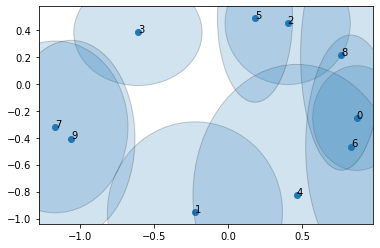

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(mu[:, 0], mu[:, 1])


for i in range(10):
    # oval
    c = pth.Ellipse(xy=(mu[i, 0], mu[i, 1]), width=sigma[i, 0], height=sigma[i, 1], fc=None, ec='black', alpha=0.2)
    ax.add_patch(c)
    # label
    plt.annotate(str(i), xy=(mu[i, 0], mu[i, 1]))